In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h3
import math
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('data/Roads_InfoAboutEachLRP.xlsx')

In [3]:
df.isnull().sum()

road        81
chainage    85
lrp         84
lat         85
lon         85
type        85
name        89
dtype: int64

In [4]:
junkdata=df[df['lat'].isna()]
junkdata.index

Index([ 1934,  3738, 11769, 11772, 11774, 11776, 11778, 11909, 13636, 13686,
       17158, 21961, 31045, 34916, 34917, 34918, 38779, 40281, 51066, 51069,
       51072, 51075, 51078, 51081, 51084, 51087, 51090, 51093, 51096, 51099,
       51102, 51106, 51107, 51109, 51313, 51315, 51319, 51323, 51326, 51328,
       51332, 51334, 51337, 51340, 51343, 51346, 51349, 51352, 51355, 51359,
       51362, 51365, 51368, 51371, 51374, 51377, 51380, 51383, 51386, 51389,
       51391, 51395, 51398, 51401, 51404, 51407, 51410, 51413, 51416, 51419,
       51422, 51424, 51428, 51430, 51434, 51437, 51440, 51443, 51445, 51451,
       51454, 51456, 51460, 51463, 51466],
      dtype='int64')

In [5]:
df[3737:3740]

,road,chainage,lrp,lat,lon,type,name
3737,N209,0.00,LRPS,24.877555,91.875360,Others,Start of the Road at Humayun Rashid Chattar In...
3738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3739,N209,0.09,LRPSa,24.878138,91.875305,Culvert,Box culvert


In [6]:
df[11770:11779]

,road,chainage,lrp,lat,lon,type,name
11770,R171,0.436,LRPSa,22.002889,91.955194,Culvert,Box culvert
11771,R171,0.975,LRPSb,22.003194,91.959972,Bridge,brije start
11772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11773,R171,0.975,LRPSb,22.003194,91.959972,Bridge,Bridge start
11774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11775,R171,0.984,LRPSc,22.003222,91.960083,Bridge,brije end
11776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11777,R171,0.984,LRPSc,22.003222,91.960083,Bridge,Bridge end
11778,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df[34915:34920] #errors arise from missing values and are removed by eliminating rows with NaN values and reindexing the whole dataframe

,road,chainage,lrp,lat,lon,type,name
34915,Z5011,0.00,LRPS,25.780583,88.914611,Others,Start at Sayedpur more Infront of Tata motors ...
34916,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34917,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34919,Z5011,0.03,LRP001,25.780360,88.914694,KmPost,Parbatipur13 km


From these observations we can see that the points at which there are no values tends to occur across rows and can be dropped altogether as not containing important data.

Now we can start with visualisation of the data to see what is the data we're working with and the types of errors that may occur in the latitudes and longitudes

<Axes: xlabel='lat', ylabel='lon'>

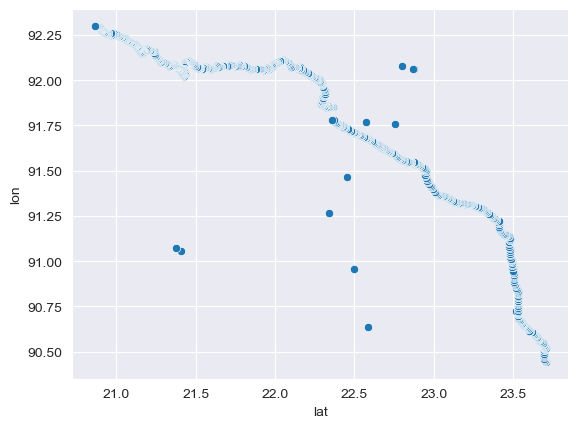

In [8]:
sns.set_style('darkgrid')
sns.scatterplot(x='lat', y='lon', data=df.loc[df.road=='N1'])

Now, in order to clean the data, we create a window of 10 values that moves across the latitude and londitude values and calculates an average value for those points. The window moves across the values for all roads and exists around each point in the road. Then for each point, it creates a filter of 0.1% error margin to check if the point is outside the error margin in each direction. If it is, then the point is moved between the two values above and below it in the dataset.

In [9]:
highList = pd.unique(df.road)

In [10]:
roadMap=pd.DataFrame()
atlas={}
for ID in highList:
    road = df.loc[df.road==ID]
    road.reset_index(drop=True) 
    road['Xchanged']='False'
    road['Ychanged']='False'
    atlas[ID]=len(road)
    if len(road)>5:
        for count in range(0,3):
            for i in road.index:           
                # check if i is inside first or last five iterations and compute moving averages acordingly 
                while i in range(5, len(road)-5):
                    x_min, x_max = road.loc[i-5:i+5,'lon'].median() * .9999 , road.loc[i-5:i+5,'lon'].median() * 1.0001 # how big do we want to make search depth?
                    y_min, y_max = road.loc[i-5:i+5,'lat'].median() * .9999 , road.loc[i-5:i+5,'lat'].median() * 1.0001 

                    if not x_min <  road.loc[i,'lon'] < x_max: # check for outliers and overwrite 
                        road.loc[i,'lon'] = (road.loc[i-1,'lon'] + road.loc[i+1,'lon']) / 2 # position point right in between last and next point
                        road.loc[i,'Xchanged']='True'

                    if not y_min < road.loc[i,'lat'] < y_max:
                        road.loc[i,'lat'] = (road.loc[i-1,'lat'] + road.loc[i+1,'lat']) / 2 # position point right in between last and next point
                        road.loc[i,'Ychanged']='True'

                    i+=1
                    break 
    roadMap=pd.concat([roadMap,road])
roadMap=roadMap.reset_index(drop=1)
errors={'X has changed':0,
     'Y has changed':0,
     'Both have changed':0,
       'No change':0}
for i in roadMap.index:
    if roadMap.loc[i,'Xchanged']=='True' and roadMap.loc[i,'Ychanged']=='True':
        errors['Both have changed']+=1
    elif roadMap.loc[i,'Xchanged']=='True':
        errors['X has changed']+=1
    elif roadMap.loc[i,'Ychanged']=='True':
        errors['Y has changed']+=1
    elif roadMap.loc[i,'Xchanged']=='False' and roadMap.loc[i,'Ychanged']=='False':
        errors['No change']+=1

We also created a column to keep track of whether or not a point was changed to see if the point moved in X direction, Y direction or on both axis. On observation, we can see that this method is not particularly good as it only captures around 3 values in X direction and 60 values in Y direction. Thus we create an even more rigid algorithm that also accounts for the 5 points at the start as well as the 5 points at the end and averages out those values as a filter.

In [11]:
for road in roadMap['road'].unique():
    for elem in roadMap.loc[roadMap['road'] == road].index:
        # NOT first or last LRP
        if elem != 0 and elem != 1 and elem != (len(roadMap.loc[roadMap['road'] == road])-1) and elem != (len(roadMap.loc[roadMap['road'] == road])-2):
                    
                #far from both neighbors
            if abs(roadMap.loc[elem, 'lat'] - roadMap.loc[elem-2, 'lat']) > 0.1 and abs(roadMap.loc[elem, 'lat'] - roadMap.loc[elem+2, 'lat']) > 0.1 :  
                    roadMap.loc[elem, 'lat'] = (roadMap.loc[elem-3, 'lat'] + roadMap.loc[elem+3, 'lat'])/2 # replace with average of neighbors
                    roadMap.loc[elem, 'lon'] = (roadMap.loc[elem-3, 'lon'] + roadMap.loc[elem+3, 'lon'])/2 # replace with average of neighbors
                    #print(road)
                    
                    #far from precursor only
            elif abs(roadMap.loc[elem, 'lat'] - roadMap.loc[elem-2, 'lat']) > 0.1 and elem > 6: 
                if abs(roadMap.loc[elem+3, 'lat'] - (roadMap.loc[elem-3, 'lat'] + abs(roadMap.loc[elem-6, 'lat'] - roadMap.loc[elem-3, 'lat']))) < abs(roadMap.loc[elem+3, 'lat'] - roadMap.loc[elem, 'lat']): # if extending linear trend of previous datapoints brings outlier closer to successor
                    roadMap.loc[elem, 'lat'] = roadMap.loc[elem-3, 'lat'] + abs(roadMap.loc[elem-6, 'lat'] - roadMap.loc[elem-3, 'lat'])
                    roadMap.loc[elem, 'lon'] = roadMap.loc[elem-3, 'lon'] + abs(roadMap.loc[elem-6, 'lon'] - roadMap.loc[elem-3, 'lon'])
                            
            # last LRP
            elif elem == len(roadMap.loc[roadMap['road'] == road])-1 or elem == len(roadMap.loc[roadMap['road'] == road])-2: 
                if abs(roadMap.loc[elem, 'lat'] - roadMap.loc[elem-3, 'lat']) > 0.1: #if far from precursor
                    roadMap.loc[elem, 'lat'] = roadMap.loc[elem-3, 'lat'] + abs(roadMap.loc[elem-6, 'lat'] - roadMap.loc[elem-3, 'lat']) #replace with linear extension of precursors
                    roadMap.loc[elem, 'lon'] = roadMap.loc[elem-3, 'lon'] + abs(roadMap.loc[elem-6, 'lon'] - roadMap.loc[elem-3, 'lon'])
                    #print(road)
           
            # first LRP
            elif elem == 0 or elem == 1: 
                if abs(roadMap.loc[elem, 'lat'] - roadMap.loc[elem+3, 'lat']) > 0.1: #if far from successor
                    roadMap.loc[elem, 'lat'] = roadMap.loc[elem+3, 'lat'] - abs(roadMap.loc[elem+3, 'lat'] - roadMap.loc[elem+6, 'lat']) #replace with linear extension of successor
                    roadMap.loc[elem, 'lon'] = roadMap.loc[elem+3, 'lon'] - abs(roadMap.loc[elem+3, 'lon'] - roadMap.loc[elem+6, 'lon'])


In [12]:
roadMap=roadMap.reset_index(drop=True)

Now we can see the N1 High way and see the improvement in the map to see if our method is capturing errors efficiently. In other highways, there are a few points that are not completely captured completely, however due to time constraints, we were unable to use this method iteratively to fix all values in their entirity. However, we are certain that this method works and is effective at capturing and correcting errors.

<Axes: xlabel='lat', ylabel='lon'>

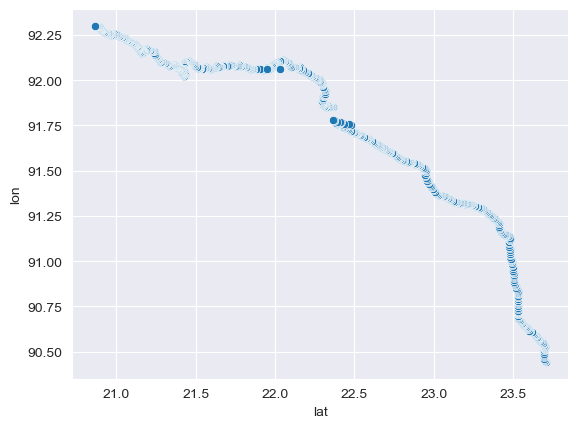

In [13]:
sns.scatterplot(x='lat',y='lon',data=roadMap.loc[roadMap.road=='N1'])

This method is used to measure the distance between two points on a curved surface (like the earth) and is most commonly used to measure the distance between latitide and longitudes of two points.

In [14]:
def haversine(lat1, lon1, lat2, lon2):

    R = 6371  # radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

Now, we can create a column that measures the same distance from the start and make it perform the same function as chainage and use it to observe the difference between the two values to observe if there are any errors in the two values and if necessary, to change the value of either chainage or distance, depending on whether or not there was an adjustment made to the latitude and longitude in the previous step.

In [15]:

roadID=''
for i in roadMap.index:
    if roadID!=roadMap.loc[i,'road']:
        distance = 0
        roadID=roadMap.loc[i,'road']
    elif i==(len(roadMap.index)-1):
        break
    else:
        x, x_next = roadMap.loc[i,'lon'], roadMap.loc[i+1,'lon']
        y, y_next = roadMap.loc[i,'lat'], roadMap.loc[i+1,'lat']
        coords_1=(x,x_next)
        coords_2=(y,y_next)
        #temp = haversine(x, y, x_next, y_next)
        #temp=math.sqrt(((x_next-x)^2)+((y_next-y)^2))
        temp = math.dist(coords_1, coords_2)

        distance+=temp
        #print(distance)
    #roadID=i
    roadMap.loc[i,'distance'] = distance

In [16]:
roadMap['difference']=roadMap['distance']-roadMap['chainage']

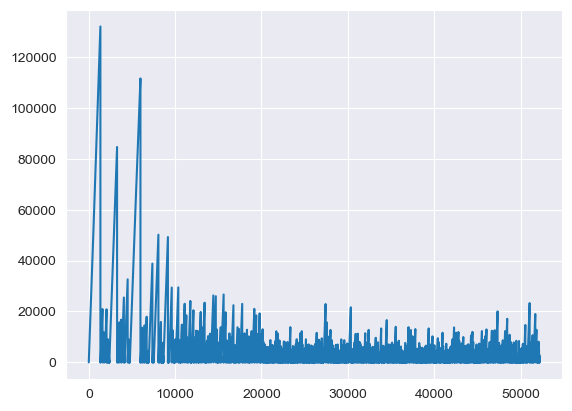

In [17]:
roadMap["difference"].plot()
plt.show()

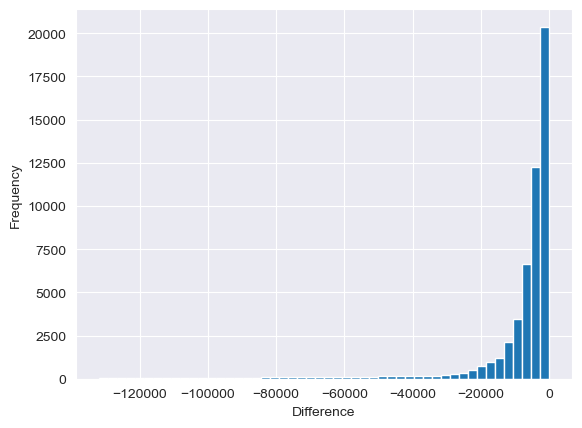

In [18]:
comparison = roadMap['chainage'] - roadMap['distance']

plt.hist(comparison, bins=50)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

On obersving this data, we can see that there are certain points where the distance is far higher than the chainage values and probably signifies an error.

We can now move on to the possibility of duplication. Since RoadLRP and Road name are separate, there are multiple LRPs that occur in the dataset for each road. Hence we create a new UniqueID to combine the two columns and see if any duplicates occur.

In [19]:
roadMap['UniqueID']=roadMap['road']+roadMap['lrp']

In [20]:
boolen = roadMap.duplicated(subset=['UniqueID'])
boolen.value_counts()

False    51928
True       286
Name: count, dtype: int64

Here, we can see that there are 286 duplicate values for road LRPs and depending on their values need to be dealt with.

In order to see how well we have corrected the data, we plot the original data and the altered data onto a map. The points in red signify the original data and the blue points signify the altered data.

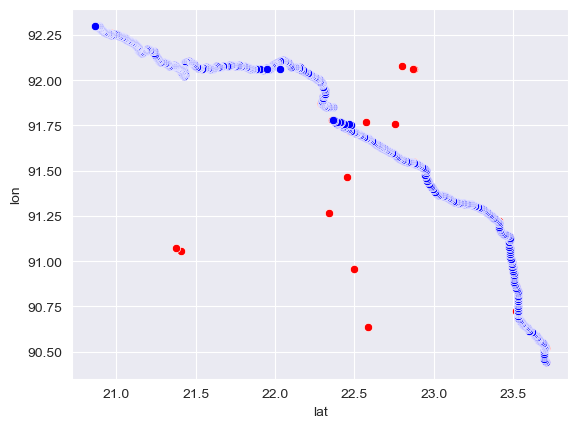

In [21]:
ID='N1'

ax= plt.subplots()
ax=sns.scatterplot(x='lat',y='lon',data=df.loc[df.road==ID],color='r')
ax=sns.scatterplot(x='lat', y='lon', data=roadMap.loc[roadMap.road==ID],color='b')

plt.show()

In [22]:
roadMap.head()

,road,chainage,lrp,lat,lon,type,name,Xchanged,Ychanged,distance,difference,UniqueID
0,N1,0.000,LRPS,23.706028,90.443333,Others,Start of Road after Jatrabari Flyover infront...,False,False,0.000000,0.000000,N1LRPS
1,N1,0.814,LRPSa,23.702917,90.450417,Culvert,Box Culvert,False,False,94.395357,93.581357,N1LRPSa
2,N1,0.822,LRPSb,23.702778,90.450472,CrossRoad,Intersection with Z1101,False,False,188.792364,187.970364,N1LRPSb
3,N1,1.000,LRP001,23.702139,90.451972,KmPost,Km post missing,False,False,283.199979,282.199979,N1LRP001
4,N1,2.000,LRP002,23.697889,90.460583,KmPost,Km post missing,False,False,377.617826,375.617826,N1LRP002


In [23]:
roadMap=roadMap.drop(columns=['Xchanged','UniqueID','Ychanged','distance','difference'])

In [24]:
roadMap.to_excel('data/processed/Roads_InfoAboutEachLRP.xlsx', index=False, sheet_name='Roads_InfoAboutEachLRP')